In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [ ]:
v = 1
w = 1
dt = 0.01

In [ ]:
# Ruido en los controles
U_noise = np.array([[np.random.normal(0,0.1)],[np.random.normal(0,0.1)]])

In [ ]:
# Ruido en las observaciones
Z_noise = np.array([[np.random.normal(0,0.01)],[np.random.normal(0,0.01)]])

In [ ]:
# Matriz de controles U
U_noisy = np.array([[v],[w]])+U_noise

In [ ]:
# Estado inicial
X = np.array([[1],[0],[0],[0],[0]])

In [ ]:
# Matriz de transición de estados
A = np.eye(X.shape[0])

In [ ]:
def pred(X_ant,A,U_noisy,dt,P,Q):
  # Calculo de B
  x_ant = X_ant[0]
  y_ant = X_ant[1]
  theta_ant = X_ant[2]
  v_ant = X_ant[3]
  w_ant = X_ant[4]
  
  X_ant = np.array([[x_ant],[y_ant],[theta_ant],[v_ant],[w_ant]])
  # Matriz de relación de estados y controles
  B = np.array([[(np.cos(theta_ant)*dt),0],[(np.sin(theta_ant)*dt),0],[0,dt],[1,0],[0,1]])
  # Estado Xt
  X = np.dot(A,X_ant) + np.dot(B,U_noisy)

  # Predicción de la covarianza
  # Jacobiano
  Gt = np.eye(X.shape[0])
  Gt[0,2] = -1*v*dt*np.sin(theta_ant)
  Gt[1,2] = v*dt*np.cos(theta_ant)
  P = np.dot(Gt,np.dot(P,Gt.T))+Q
  return X,P

In [ ]:
def obs_diff(X_pred,Z_noise):
  x = X_pred[0,0]
  y = X_pred[1,0]
  r_z = np.sqrt(x**2+y**2)
  phi_z = np.arctan(y/x)
  Zt_noisy = np.array([[r_z],[phi_z]])+Z_noise
  hX_pred = np.array([[r_z],[phi_z]])
  return Zt_noisy-hX_pred



In [ ]:
def correction(X_pred,P_pred,cov_obs,Z_noise):
  x = X_pred[0]
  y = X_pred[1]
  theta = X_pred[2]
  v = X_pred[3]
  w = X_pred[4]
  
  X_pred = np.array([[x],[y],[theta],[v],[w]])
  
  # Jacobiano
  Ht = np.zeros((2,5))
  Ht[0,0] = x/np.sqrt(x**2+y**2)
  Ht[0,1] = y/np.sqrt(x**2+y**2)
  Ht[1,0] = -1*y/(x**2+y**2)
  Ht[1,1] = x/(x**2+y**2)
  # Kt
  term = np.linalg.inv(np.dot(Ht,np.dot(P_pred,Ht.T))+cov_obs)
  Kt = np.dot(P_pred,np.dot(Ht.T,term))
  # Corrección del estado
  term_1 = obs_diff(X_pred,Z_noise)
  X_corr = X_pred + np.dot(Kt,term_1)

  # Corrección de la covarianza
  term_2 = np.eye(X.shape[0]) - np.dot(Kt,Ht) 
  P_corr = np.dot(term_2,P_pred)
  return X_corr,P_corr

In [ ]:
# Matriz de covarianza de estado
Q = np.eye(X.shape[0])
# Predicción de la covarianza del estado inicial
P = 0.5*np.eye(X.shape[0])

In [ ]:
# Variable de estados
X_pred = X
# Variable de covarianzas
P_pred = []
P_pred.append(P) 

In [ ]:
# Matriz de covarianza de las observaciones
cov_obs = 0.01*np.eye(2)

In [ ]:
X_corr = X
P_corr = []
P_corr.append(P)

In [ ]:
state = 1
while state < 1000:
  # Predicción
  X,P = pred(X_pred[:,(state-1)],A,U_noisy,dt,P_pred[state-1],Q)
  X_pred = np.concatenate([X_pred,X],axis=1)
  P_pred.append(P)
  # Corrección
  X_corr_temp,P_corr_temp = correction(X_pred[:,state],P_pred[state],cov_obs,Z_noise)
  X_corr = np.concatenate([X_corr,X_corr_temp],axis=1)
  P_corr.append(P_corr_temp)
  
  state = state + 1

In [ ]:
x = []
y = []
x_corr = []
y_corr = []
for i in range(X_pred.shape[1]):
  x.append(X_pred[0,i]) 
  y.append(X_pred[1,i])
  x_corr.append(X_corr[0,i]) 
  y_corr.append(X_corr[1,i]) 

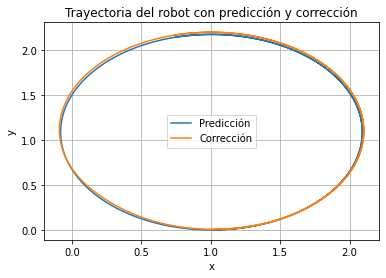

In [ ]:
plt.title('Trayectoria del robot con predicción y corrección')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.plot(x,y,label = 'Predicción')
plt.plot(x_corr,y_corr,label = 'Corrección')
plt.legend()